In [89]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [90]:
# Importing necessary libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from PIL import Image

In [91]:
labels = open('./coco.names').read().strip().split('\n')  # list of names classes
print(labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [92]:
weights_path = './yolov3.weights'
configuration_path = './yolov3.cfg'

# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5
# Setting minimum probability to eliminate weak predictions
probability_minimum = 0.5

# Setting threshold for non maximum suppression
threshold = 0.3

network = cv2.dnn.readNetFromDarknet(configuration_path, weights_path)

# Getting names of all layers
layers_names_all = network.getLayerNames()  # list of layers' names
#print(layers_names_all)

In [93]:
layers_names_output = [layers_names_all[i - 1] for i in network.getUnconnectedOutLayers()]  # list of layers' names

# Check point
print(layers_names_output)  # ['yolo_82', 'yolo_94', 'yolo_106']

['yolo_82', 'yolo_94', 'yolo_106']


In [94]:
image_input = cv2.imread('./atlar.jpg')

# Getting image shape
image_input_shape = image_input.shape

# Check point
print(image_input_shape)

(461, 1400, 3)


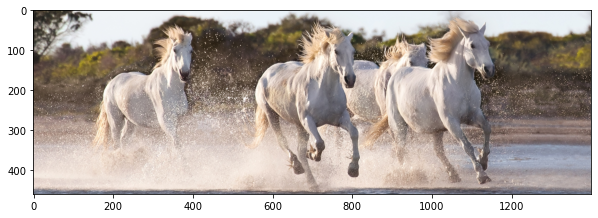

In [95]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.imshow(cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB))
plt.show()

In [96]:
blob = cv2.dnn.blobFromImage(image_input, 1 / 255.0, (416, 416), swapRB=True, crop=False)

# Check point
print(image_input.shape)  
print(blob.shape) 

(461, 1400, 3)
(1, 3, 416, 416)


(416, 416, 3)


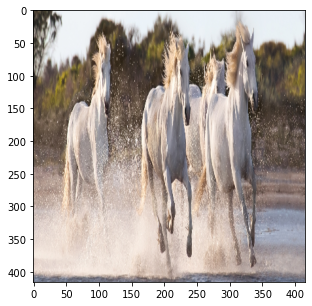

In [97]:
blob_to_show = blob[0, :, :, :].transpose(1, 2, 0)
print(blob_to_show.shape)  # (416, 416, 3)

# Showing 'blob_to_show'
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(blob_to_show)
plt.show()

In [98]:
network.setInput(blob)  # setting blob as input to the network
start = time.time()
output_from_network = network.forward(layers_names_output)
end = time.time()

# Showing spent time for forward pass
print('YOLO v3 took {:.5f} seconds'.format(end - start))

YOLO v3 took 0.52125 seconds


In [99]:
print(type(output_from_network))  # <class 'list'>
print(type(output_from_network[0]))  # <class 'numpy.ndarray'>

<class 'tuple'>
<class 'numpy.ndarray'>


In [100]:
np.random.seed(42)
# randint(low, high=None, size=None, dtype='l')
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

# Check point
print(colours.shape)  
print(colours[0])  

(80, 3)
[102 220 225]


In [101]:
# Preparing lists for detected bounding boxes, obtained confidences and class's number
bounding_boxes = []
confidences = []
class_numbers = []

In [102]:
# Getting spacial dimension of input image
h, w = image_input_shape[:2]  # Slicing from tuple only first two elements

# Check point
print(h, w)  

461 1400


In [103]:
for result in output_from_network:
    # Going through all detections from current output layer
    for detection in result:
        # Getting class for current object
        scores = detection[5:]
        class_current = np.argmax(scores)

        # Getting confidence (probability) for current object
        confidence_current = scores[class_current]

        # Eliminating weak predictions by minimum probability
        if confidence_current > probability_minimum:
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps center of detected box and its width and height
            # That is why we can just elementwise multiply them to the width and height of the image
            box_current = detection[0:4] * np.array([w, h, w, h])

            # From current box with YOLO format getting top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current.astype('int')
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [104]:
# It is needed to make sure the data type of the boxes is 'int'
# and the type of the confidences is 'float'
# https://github.com/opencv/opencv/issues/12789
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences, probability_minimum, threshold)

# Check point
# Showing labels of the detected objects
for i in range(len(class_numbers)):
    print(labels[int(class_numbers[i])])

# Saving found labels
with open('found_labels.txt', 'w') as f:
    for i in range(len(class_numbers)):
        f.write(labels[int(class_numbers[i])])

horse
horse
horse
horse
horse
horse
horse
horse
horse
horse


In [105]:
our_need_class = ['car','bus','truck','motorbike','horse'] # At this list wa add only class, what we need. If you want cut after all objects, remove this list
list_box = []
coordinates_need_object = []
class_object = []
# Checking if there is at least one detected object
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Getting current bounding box coordinates
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        colour_box_current = [int(j) for j in colours[class_numbers[i]]]

        # Drawing bounding box on the original image
        cv2.rectangle(image_input, (x_min, y_min), (x_min + box_width, y_min + box_height),
                      colour_box_current, 5)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}:{:.4f}'.format(labels[int(class_numbers[i])], confidences[i])
        
        # Add in our list coordinate boxes and class with probability
        if labels[int(class_numbers[i])] in our_need_class:
            
            coordinates_need_object.append([x_min, y_min,x_min + box_width, y_min + box_height])
            
            # Add in our list name and probability class
            class_object.append(text_box_current)
        else:
            pass

        # Putting text with label and confidence on the original image
        cv2.putText(image_input, text_box_current, (x_min, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, colour_box_current, 5)

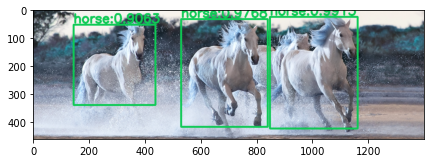

(461, 1400, 3)


In [106]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
plt.imshow(image_input)
plt.show()

print(image_input.shape)

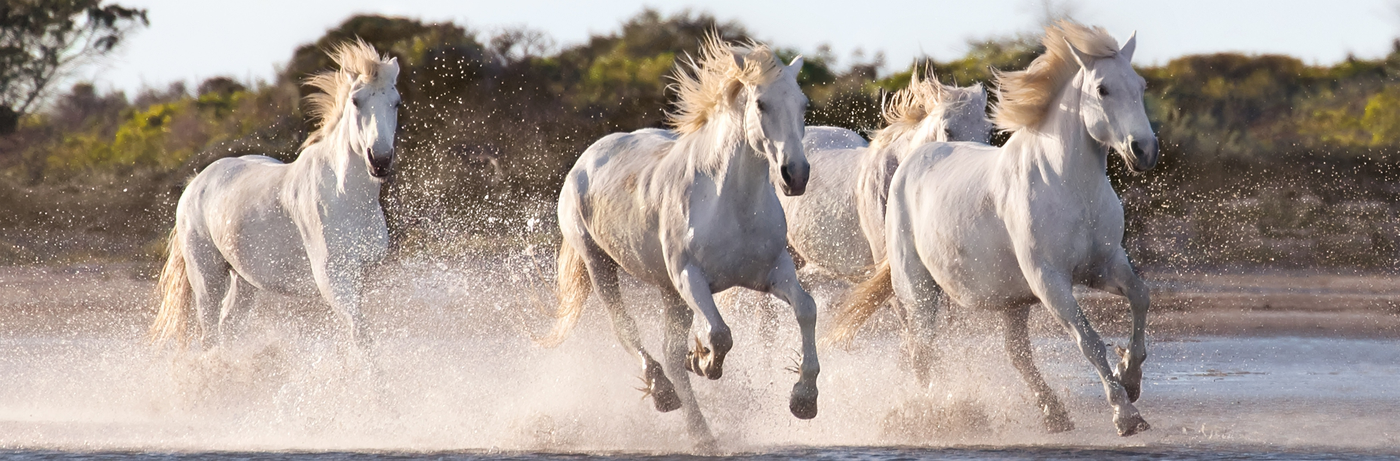

In [107]:
image_for_crop = Image.open('./atlar.jpg')
image_for_crop

At this picture we have : horse:0.9913 
This has coordinates : [848, 24, 1162, 423]


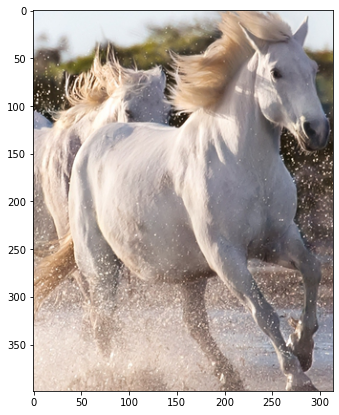

At this picture we have : horse:0.9768 
This has coordinates : [530, 32, 840, 417]


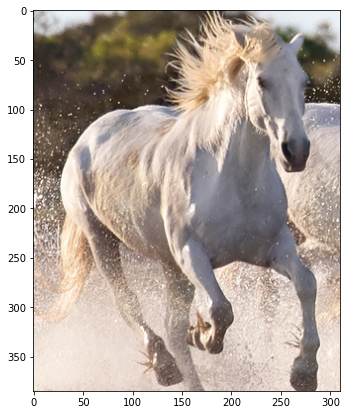

At this picture we have : horse:0.9063 
This has coordinates : [145, 52, 438, 339]


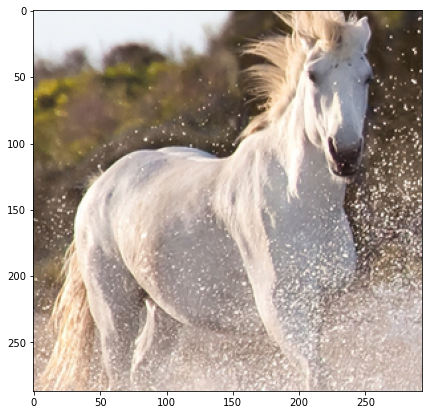

In [108]:
# create a cycle in which we cut out all objects by their coordinates
list_names_cut_objects = []
for i in range(len(class_object)):
    name_cut_obj = f'Cut_object_{class_object[i]}.jpg'
    list_names_cut_objects.append(name_cut_obj)
    im_crop = image_for_crop.crop((coordinates_need_object[i]))
    print(f'At this picture we have : {class_object[i]} \nThis has coordinates : {coordinates_need_object[i]}')
    im_crop.save(f'{name_cut_obj}', quality=100)
    cut_image = Image.open(f'./{name_cut_obj}')
    plt.imshow(cut_image)
    plt.show()

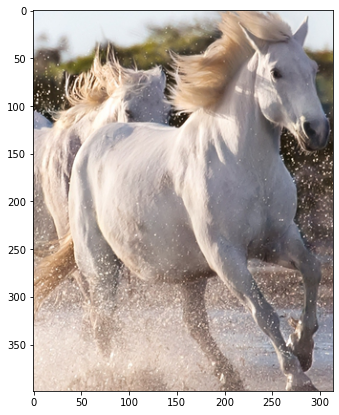

At this object we have colors in RGB format : Red = 171 , Green = 158 , Blue = 151


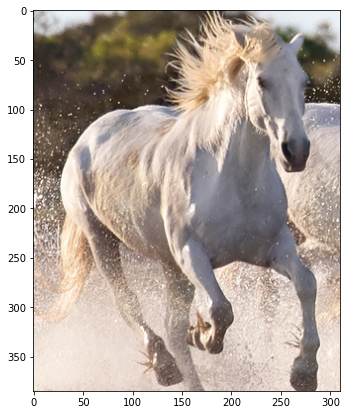

At this object we have colors in RGB format : Red = 169 , Green = 155 , Blue = 145


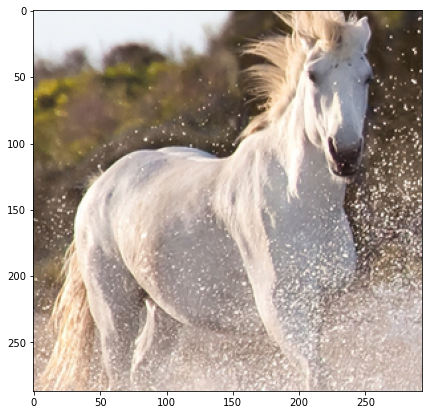

At this object we have colors in RGB format : Red = 169 , Green = 155 , Blue = 144


In [109]:
# create a cycle in which we find colors our cut objects
for i in list_names_cut_objects:
    cut_image = Image.open(f'./{i}')
    plt.imshow(cut_image)
    plt.show()
    width = cut_image.size[0]  # width
    height = cut_image.size[1]  # hight
    pix_cut = cut_image.load()  # load amount pixel
    reds_list = []     # list all value red color pixels
    greens_list = []    # green color pixels
    blues_list = []     # blue color pixels
    reds_sum = 0      # for search mean value red color
    greens_sum = 0    # green
    blues_sum = 0     # blue
    for x in range(width):
        for y in range(height):
            r = pix_cut[x, y][0] #find value red color pixel
            reds_list.append(r)
            reds_sum += r
            g = pix_cut[x, y][1] #green value
            greens_list.append(g)
            greens_sum += g
            b = pix_cut[x, y][2] #blue value
            blues_list.append(b)
            blues_sum += b
    print(f'At this object we have colors in RGB format : Red = {int(reds_sum / len(reds_list))} , Green = {int(greens_sum / len(greens_list))} , Blue = {int(blues_sum / len(blues_list))}')

# All this just one code cell


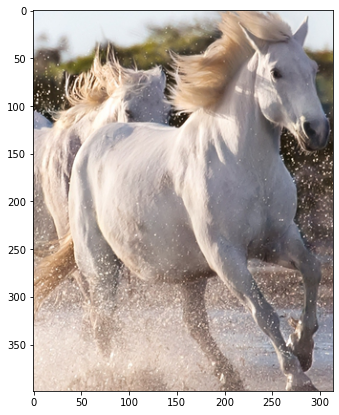

At our picture we have:
Object : his probability  =  horse:0.9913  
Colors in RGB format :
Red = 171 
Green = 158 
Blue = 151


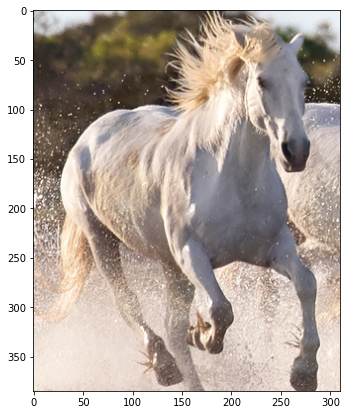

At our picture we have:
Object : his probability  =  horse:0.9768  
Colors in RGB format :
Red = 169 
Green = 155 
Blue = 145


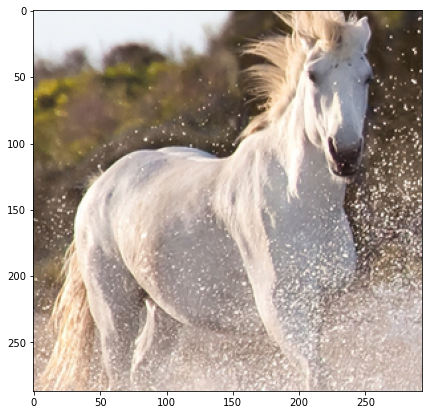

At our picture we have:
Object : his probability  =  horse:0.9063  
Colors in RGB format :
Red = 169 
Green = 155 
Blue = 144


In [110]:
image_for_crop = Image.open('./atlar.jpg')
for i in range(len(class_object)):
    name_cut_obj = f'Cut_object_{class_object[i]}.jpg'
    im_crop = image_for_crop.crop((coordinates_need_object[i]))
    im_crop.save(f'{name_cut_obj}', quality=100)
    cut_image = Image.open(f'./{name_cut_obj}')
    plt.imshow(cut_image)
    plt.show()
    width = cut_image.size[0]  # width
    height = cut_image.size[1]  # hight
    pix_cut = cut_image.load()  # load amount pixel
    reds_list = []     # list all value red color pixels
    greens_list = []    # green color pixels
    blues_list = []     # blue color pixels
    reds_sum = 0      # for search mean value red color
    greens_sum = 0    # green
    blues_sum = 0     # blue
    for x in range(width):
        for y in range(height):
            r = pix_cut[x, y][0] #find value red color pixel
            reds_list.append(r)
            reds_sum += r
            g = pix_cut[x, y][1] #green value
            greens_list.append(g)
            greens_sum += g
            b = pix_cut[x, y][2] #blue value
            blues_list.append(b)
            blues_sum += b
    print(f'At our picture we have:\nObject : his probability  =  {class_object[i]}  \nColors in RGB format :\nRed = {int(reds_sum / len(reds_list))} \nGreen = {int(greens_sum / len(greens_list))} \nBlue = {int(blues_sum / len(blues_list))}')